Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 8
  - _**[Gradient Boosting Explained](https://www.gormanalysis.com/blog/gradient-boosting-explained/)**_ — Ben Gorman
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) — Alex Rogozhnikov
  - [How to explain gradient boosting](https://explained.ai/gradient-boosting/) — Terence Parr & Jeremy Howard

In [0]:
!pip install pandas-profiling==2.*
!pip install category_encoders==2.*

In [63]:
!pip install eli5

     |████████████████████████████████| 112kB 3.4MB/s 


In [64]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from pandas_profiling import ProfileReport
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import eli5
from eli5.sklearn import PermutationImportance

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [46]:
data = pd.read_csv('hotel_bookings.csv')
data

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,0.0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07


In [47]:
#baseline
majority_class = data['is_canceled'].value_counts().index[0]
y_pred = [majority_class] * len(data['is_canceled'])
y_true = data['is_canceled']

accuracy_score(y_true, y_pred)

0.6295837172292487

In [48]:
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

profile

In [49]:
train, test = train_test_split(data, test_size=.2, random_state=42)
train, val = train_test_split(train, test_size=.2, random_state=42)
train.shape, val.shape, test.shape

((76409, 32), (19103, 32), (23878, 32))

In [0]:
def wrangle(x):
    x = x.copy()
    x['reservation_status_date'] = x['reservation_status_date'].apply(lambda x: pd.to_datetime(x, infer_datetime_format=True))
    return x

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [51]:
target = 'is_canceled'
train_features = train.drop(columns=[target, 'reservation_status'])
numeric_features = train_features.select_dtypes(include='number').columns.tolist()
cardinality = train_features.select_dtypes(exclude='number').nunique()
categorical_features = cardinality[cardinality <= 50].index.tolist()

features = numeric_features + categorical_features

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
)

pipeline.fit(X_train, y_train)
pipeline.score(X_val, y_val)

0.8716431974035492

In [58]:
#using xgboost in a pipeline
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    XGBClassifier(n_estimators=500, n_jobs=-1, random_state=42)
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
accuracy_score(y_val, y_pred)

0.8443699942417421

In [59]:
encoder = ce.OneHotEncoder()
scaler = StandardScaler()
imputer = SimpleImputer()

X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)

X_train_imputed = imputer.fit_transform(X_train_scaled)
X_val_imputed = imputer.transform(X_val_scaled)

model = XGBClassifier(
    n_estimators=1000,
    max_depth=7,
    learning_rate=.5,
    n_jobs=-1
)

eval_set = [(X_train_encoded, y_train),
            (X_val_encoded, y_val)]

model.fit(X_train_encoded, y_train,
          eval_set=eval_set,
          eval_metric='error',
          early_stopping_rounds=50)

[0]	validation_0-error:0.186889	validation_1-error:0.185364
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.18681	validation_1-error:0.186201
[2]	validation_0-error:0.181929	validation_1-error:0.182066
[3]	validation_0-error:0.179979	validation_1-error:0.179501
[4]	validation_0-error:0.175006	validation_1-error:0.175627
[5]	validation_0-error:0.172755	validation_1-error:0.174213
[6]	validation_0-error:0.171184	validation_1-error:0.172486
[7]	validation_0-error:0.169116	validation_1-error:0.171387
[8]	validation_0-error:0.165229	validation_1-error:0.167565
[9]	validation_0-error:0.164915	validation_1-error:0.167094
[10]	validation_0-error:0.160675	validation_1-error:0.165
[11]	validation_0-error:0.160308	validation_1-error:0.16521
[12]	validation_0-error:0.157154	validation_1-error:0.162331
[13]	validation_0-error:0.156906	validation_1-error:0.161755


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

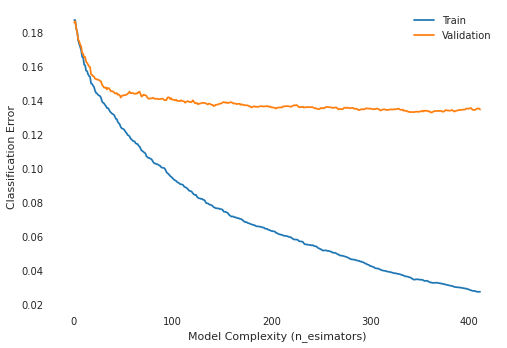

In [61]:
results = model.evals_result()
train_error = results['validation_0']['error']
val_error = results['validation_1']['error']
epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_esimators)')
plt.legend();


In [65]:
transformers = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler()
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [67]:
permuter = PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fr

In [80]:
encoder = transformers.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
encoded_columns

feature_names = encoded_columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

arrival_date_month_May        -0.000984
arrival_date_month_April      -0.000942
arrival_date_month_July       -0.000461
meal_HB                       -0.000429
arrival_date_month_February   -0.000419
                                 ...   
assigned_room_type_A           0.023159
agent                          0.024572
previous_cancellations         0.029817
lead_time                      0.035094
total_of_special_requests      0.061299
Length: 79, dtype: float64

In [81]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.0613 ± 0.0028,total_of_special_requests
0.0351 ± 0.0029,lead_time
0.0298 ± 0.0023,previous_cancellations
0.0246 ± 0.0011,agent
0.0232 ± 0.0023,assigned_room_type_A
0.0175 ± 0.0012,market_segment_Online TA
0.0154 ± 0.0035,adr
0.0126 ± 0.0012,deposit_type_No Deposit
0.0109 ± 0.0010,required_car_parking_spaces
0.0108 ± 0.0019,arrival_date_year


In [110]:
minimum_importance = 0
mask = permuter.feature_importances_ > minimum_importance
features = X_train_encoded.columns[mask]
X_train = X_train_encoded[features]

X_val = X_val_encoded[features]
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)
pipeline.score(X_val, y_val)

0.8738941527508768